In [1]:
import numpy as np
import os
import pandas as pd
from isegm.data.datasets import Lidc2dDataset
from torch.utils.data import DataLoader
from albumentations import Compose, Normalize
from isegm.inference.utils import get_iou, get_f1_score
from isegm.classical_approaches.snake_fill import SnakeMasker
from isegm.classical_approaches.flood_fill import FloodMasker
from isegm.data.preprocess import Preprocessor
import cv2
import wandb
import matplotlib.pyplot as plt

In [9]:
 def compute_scores(treshold, data_loader):
    masker = SnakeMasker(circle_size=treshold)
    iou_scores = []
    f1_scores = []
    for i, (image, gt_mask) in enumerate(data_loader):
        print(f'Testing image: {i}, Threshold: {treshold}, Progress: {i/len(data_loader) * 100:.2f}%')
        image_np = image.squeeze().squeeze().numpy()
        gt_mask = gt_mask.squeeze().numpy()
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            gt_mask.astype(np.uint8)
        )
        coords = [
            (int(centroids[label][0]), int(centroids[label][1]))
            for label in range(1, num_labels)
        ][0:1] # only first centroid

        pred_mask = masker.predict(image_np, coords).astype(bool)
        
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image_np, cmap='gray')
        ax[0].set_title('Image')
        ax[1].imshow(gt_mask, cmap='gray')
        ax[1].set_title('Ground Truth')
        ax[2].imshow(pred_mask, cmap='gray')
        ax[2].set_title(f'Prediction, Treshold: {treshold}, IOU: {get_iou(gt_mask, pred_mask):.2f}')
        
        iou_scores.append(get_iou(gt_mask, pred_mask))
        f1_scores.append(get_f1_score(gt_mask, pred_mask))
    return np.mean(iou_scores), np.mean(f1_scores)

In [10]:
base_path = '/gpfs/space/projects/PerkinElmer/donatasv_experiments/datasets/processed_datasets/LIDC-2D'
train_dataset_name = 'train'
val_dataset_name = 'val'
test_dataset_name = 'test'
batch_size = 1
circle_size_range = np.arange(1, 25, 1)  # example range for circle size
# threshold_range = np.arange(0.05, 2.001, 0.025)
# Define transformations for normalization
transformations = Compose([Normalize(mean=0, std=1)])
preprocessor = Preprocessor()
preprocessor.normalize = False
preprocessor.windowing = True
preprocessor.num_input_channels = 1
preprocessor.window_min = -900
preprocessor.window_max = 600
# Prepare the train dataset
train_dataset_path = os.path.join(base_path, train_dataset_name)
train_dataset = Lidc2dDataset(
    data_dir=train_dataset_path, transform=transformations, preprocessor=preprocessor
)
train_dataset.file_names = train_dataset.file_names[0:1]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Testing image: 0, Threshold: 1, Progress: 0.00%
Testing image: 0, Threshold: 2, Progress: 0.00%
Testing image: 0, Threshold: 3, Progress: 0.00%
Testing image: 0, Threshold: 4, Progress: 0.00%
Testing image: 0, Threshold: 5, Progress: 0.00%
Testing image: 0, Threshold: 6, Progress: 0.00%
Testing image: 0, Threshold: 7, Progress: 0.00%
Testing image: 0, Threshold: 8, Progress: 0.00%
Testing image: 0, Threshold: 9, Progress: 0.00%
Testing image: 0, Threshold: 10, Progress: 0.00%
Testing image: 0, Threshold: 11, Progress: 0.00%
Testing image: 0, Threshold: 12, Progress: 0.00%
Testing image: 0, Threshold: 13, Progress: 0.00%
Testing image: 0, Threshold: 14, Progress: 0.00%
Testing image: 0, Threshold: 15, Progress: 0.00%
Testing image: 0, Threshold: 16, Progress: 0.00%
Testing image: 0, Threshold: 17, Progress: 0.00%
Testing image: 0, Threshold: 18, Progress: 0.00%
Testing image: 0, Threshold: 19, Progress: 0.00%
Testing image: 0, Threshold: 20, Progress: 0.00%
Testing image: 0, Threshold: 

/gpfs/space/home/donatasv/.conda/envs/bcv_clickseg/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Testing image: 0, Threshold: 22, Progress: 0.00%
Testing image: 0, Threshold: 23, Progress: 0.00%
Testing image: 0, Threshold: 24, Progress: 0.00%


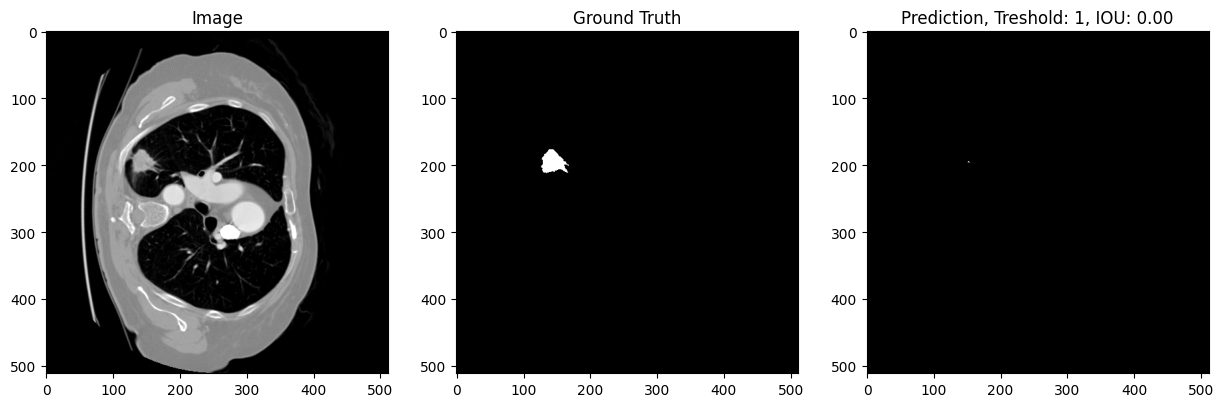

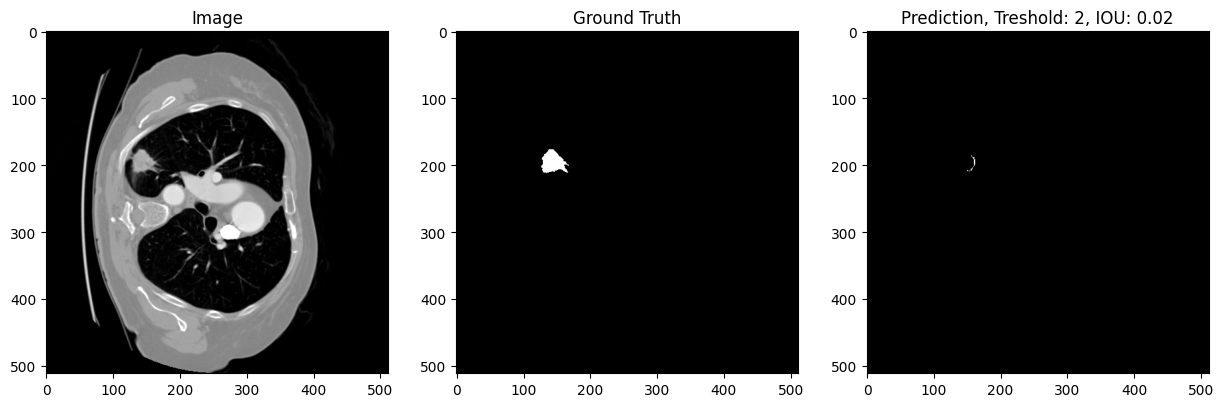

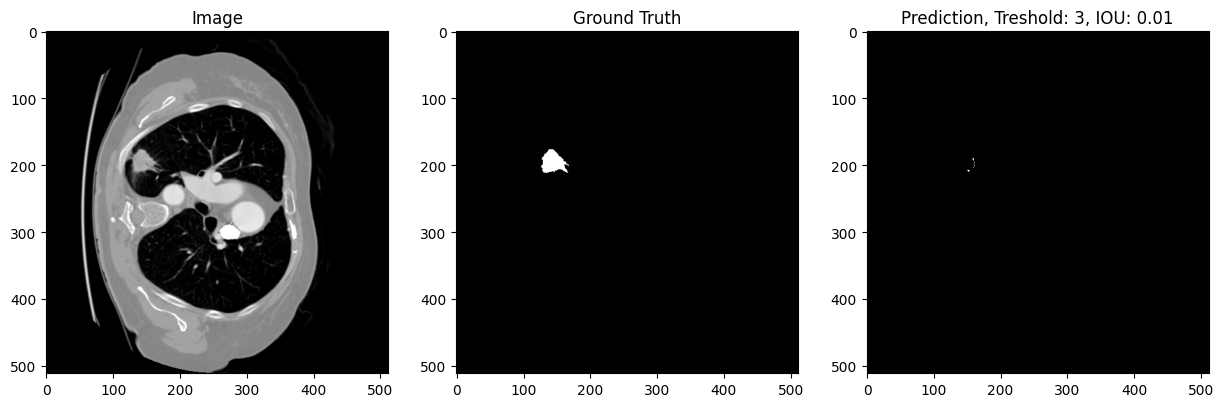

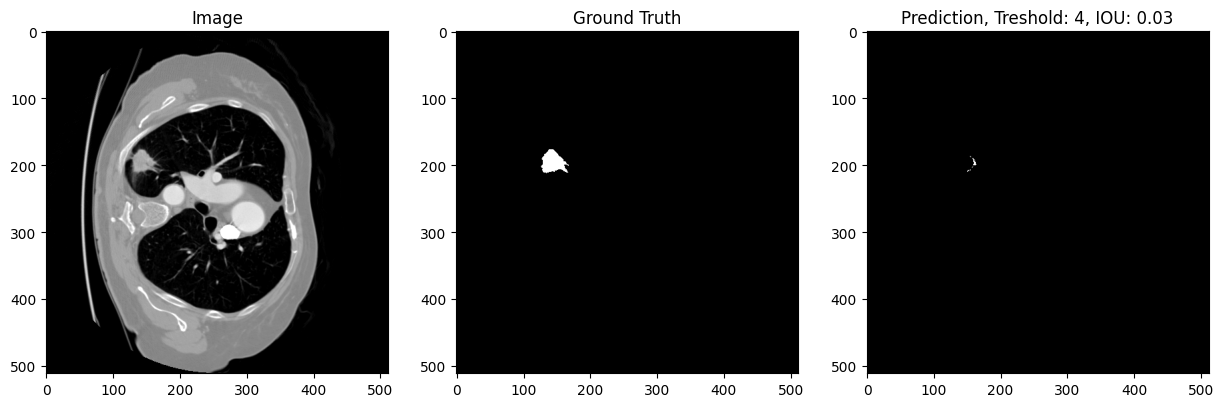

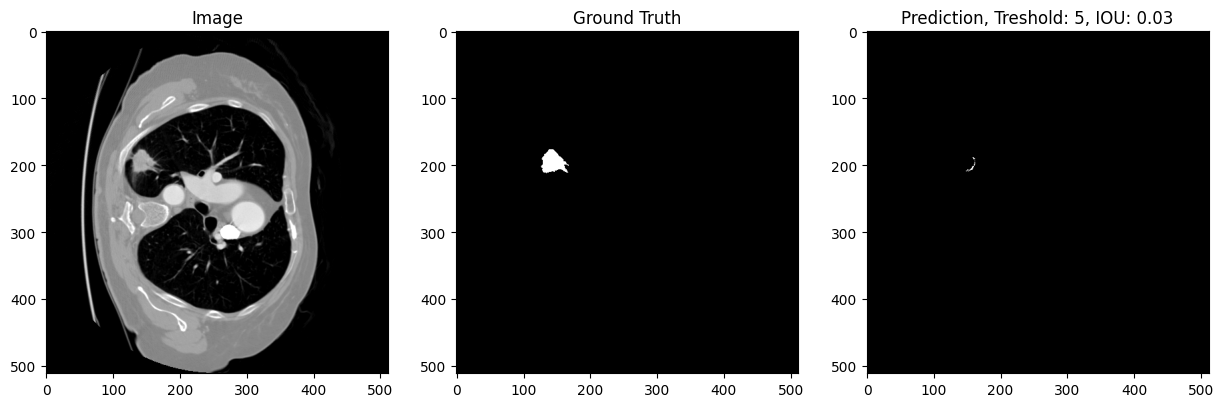

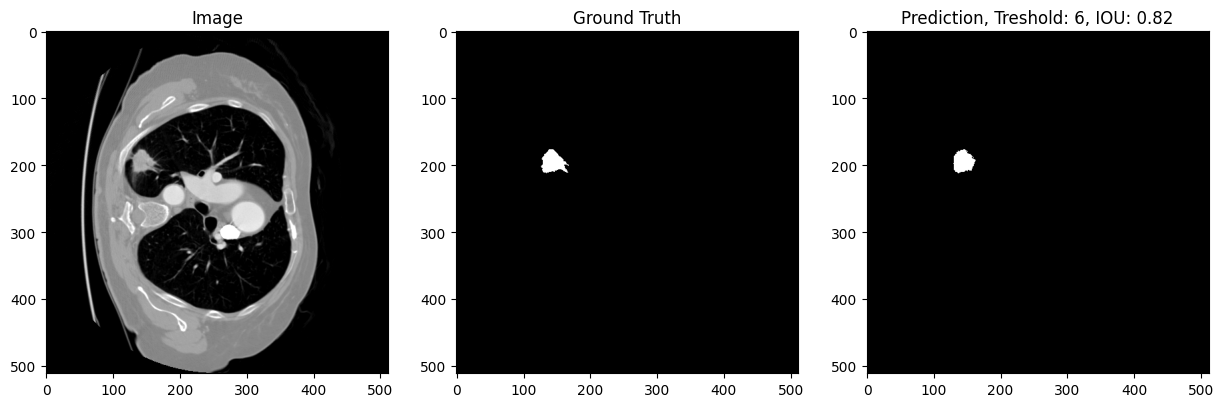

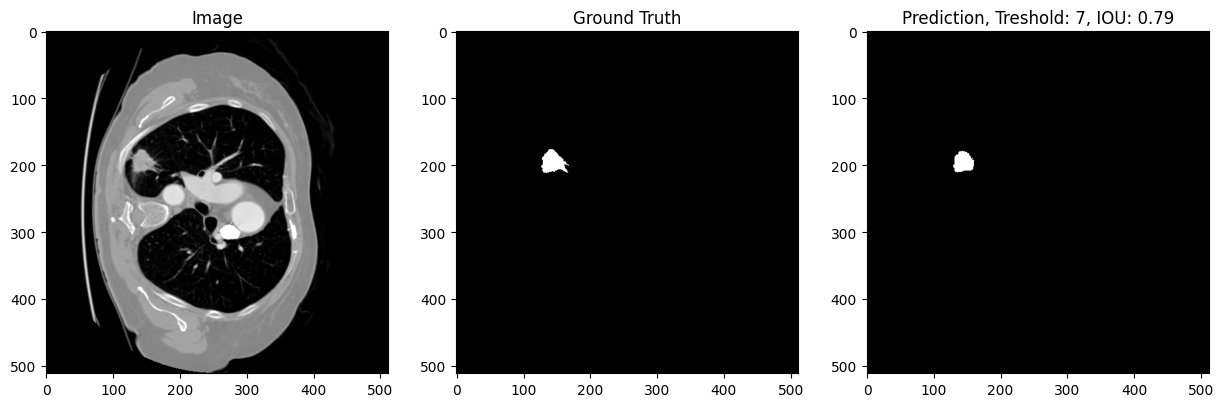

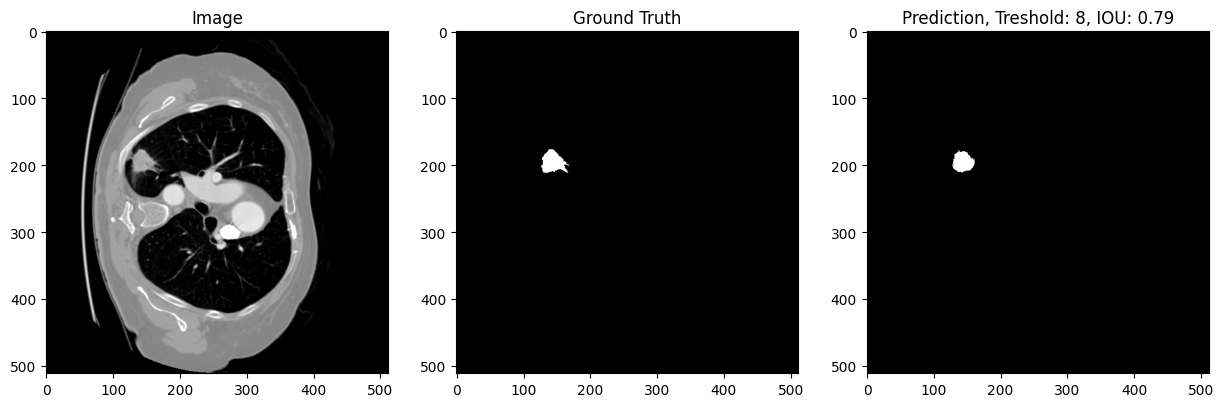

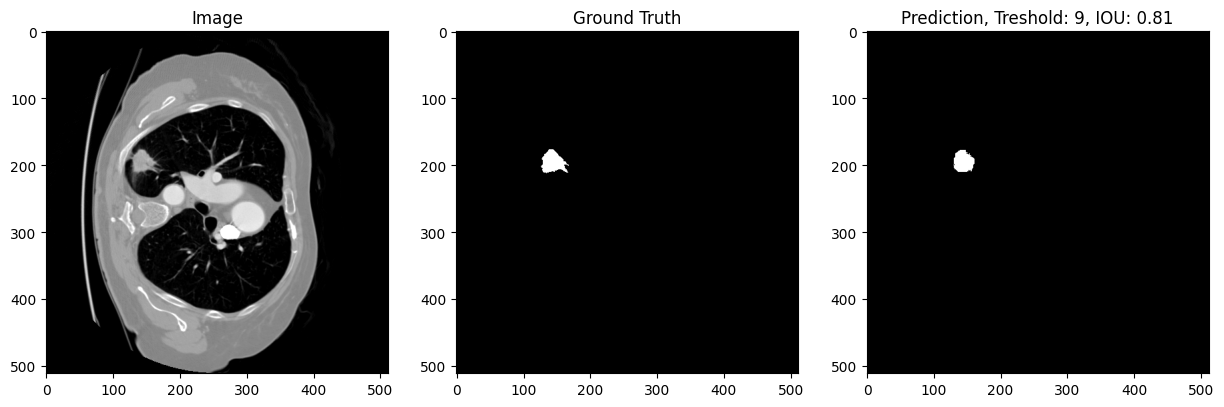

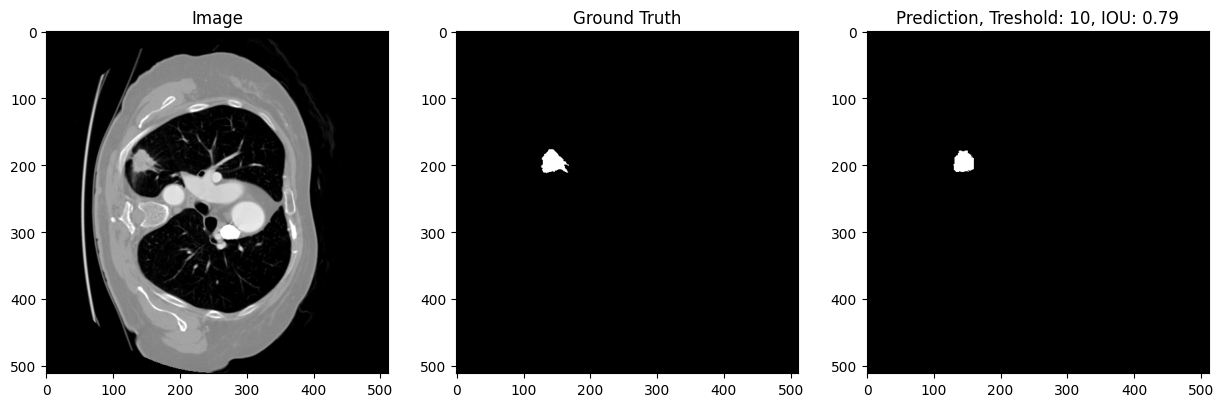

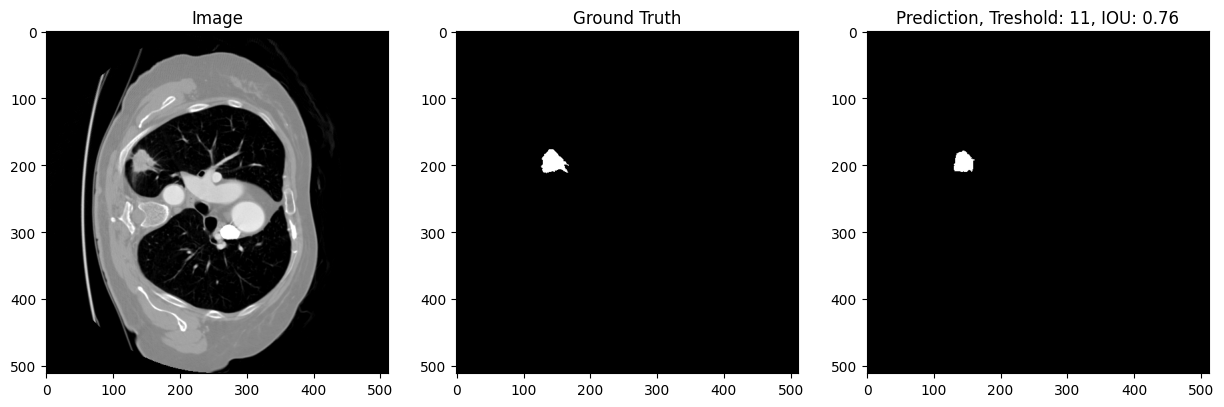

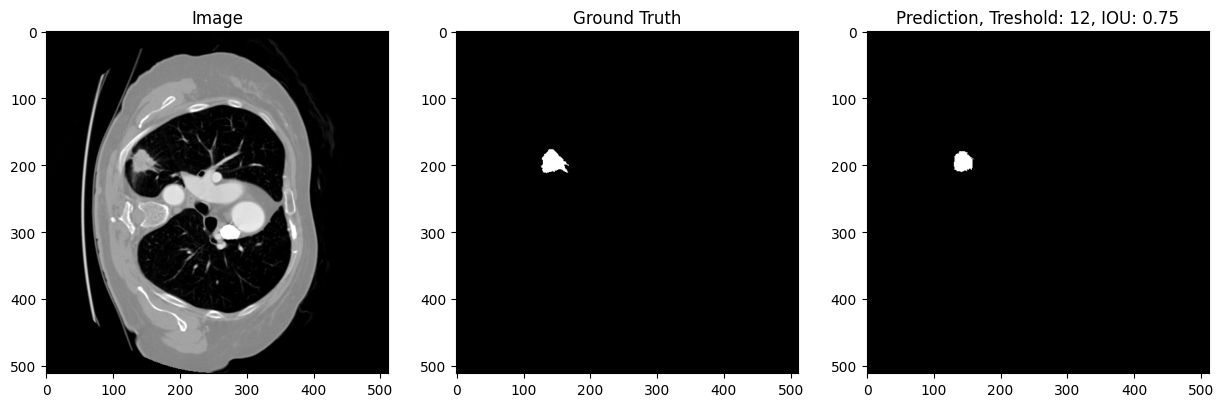

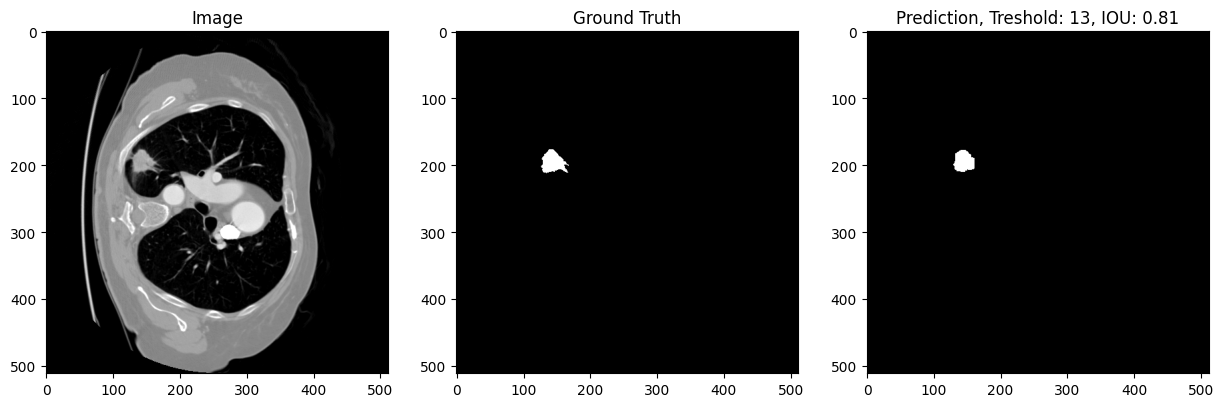

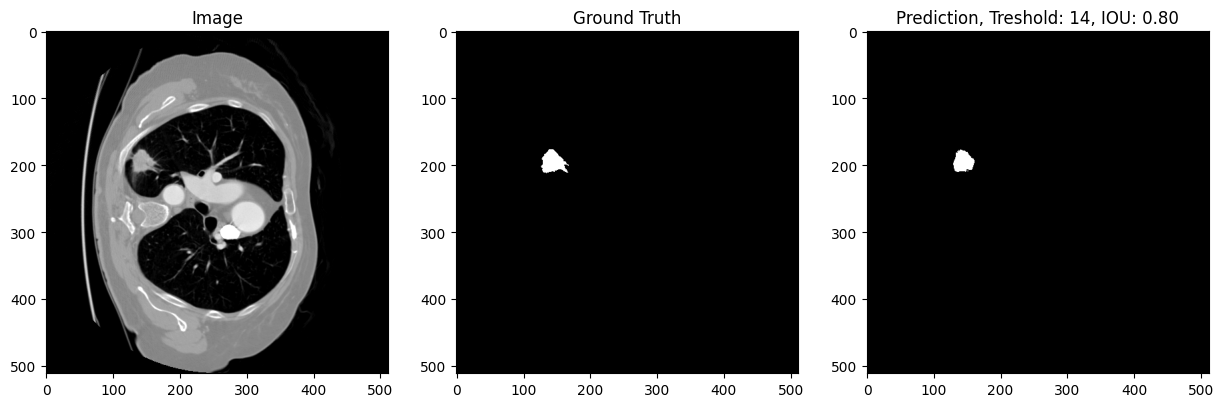

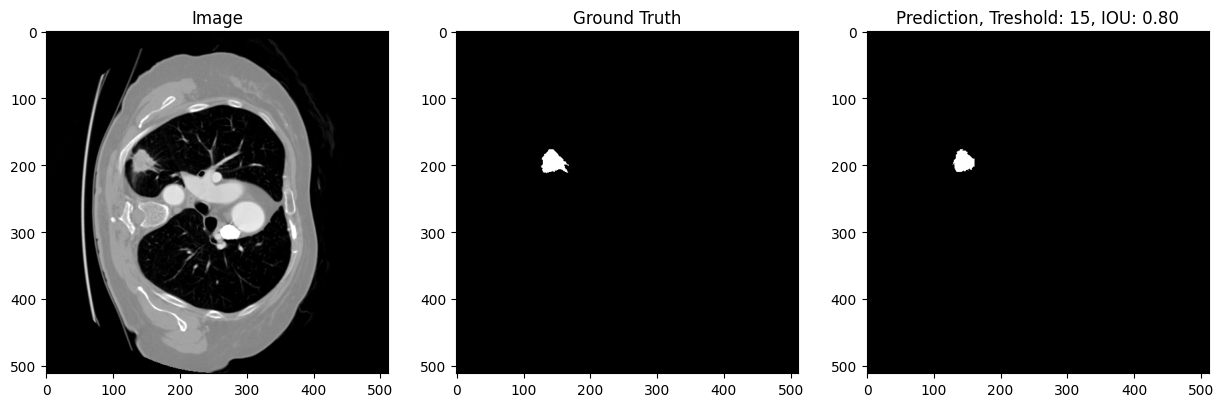

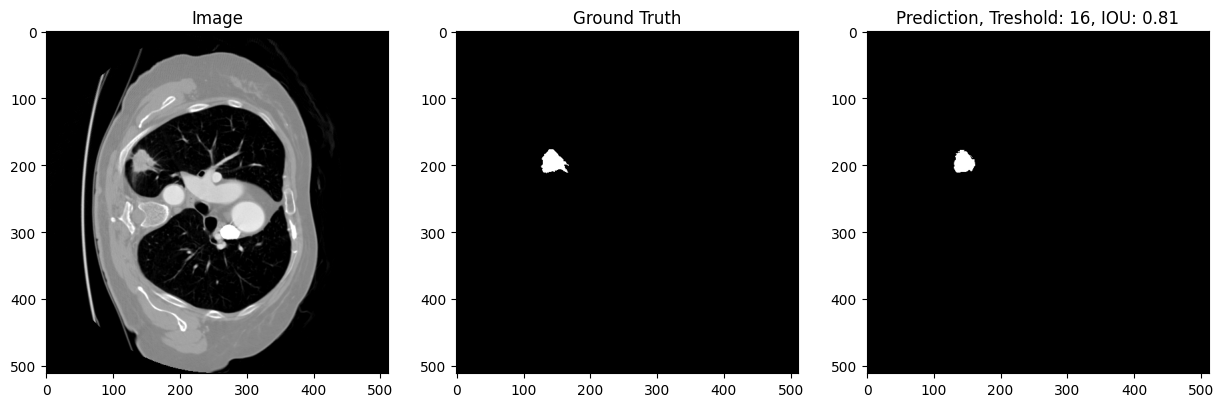

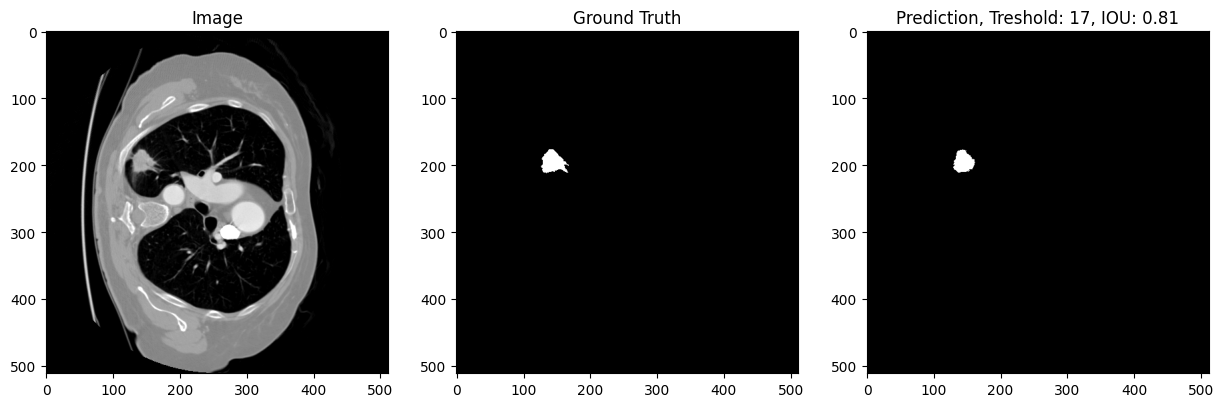

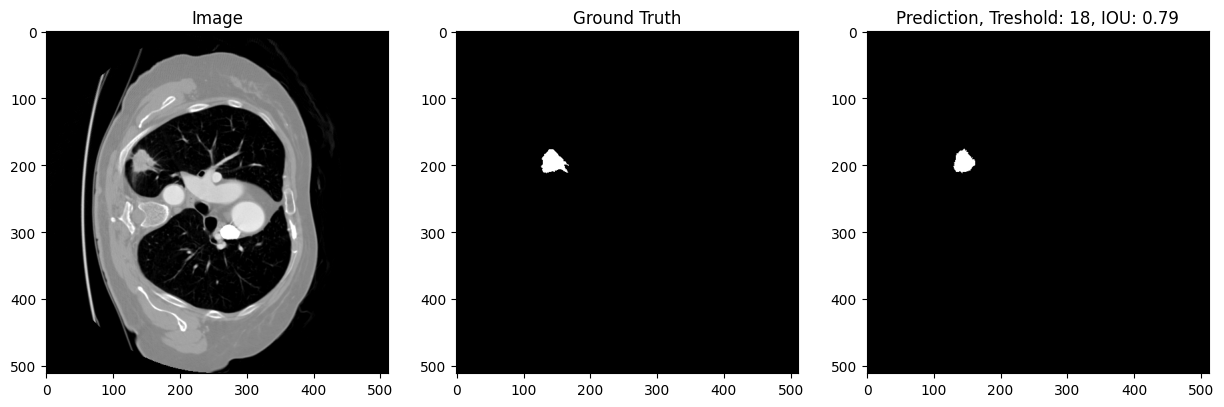

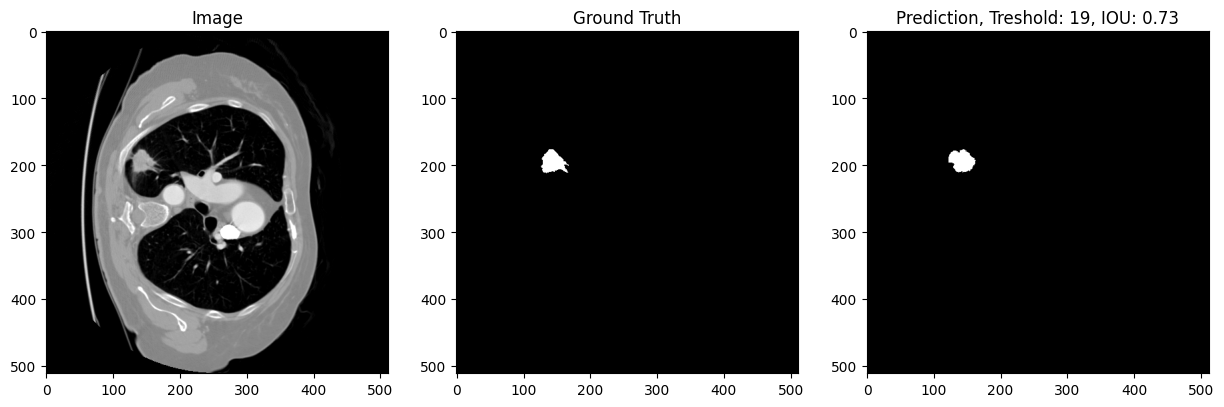

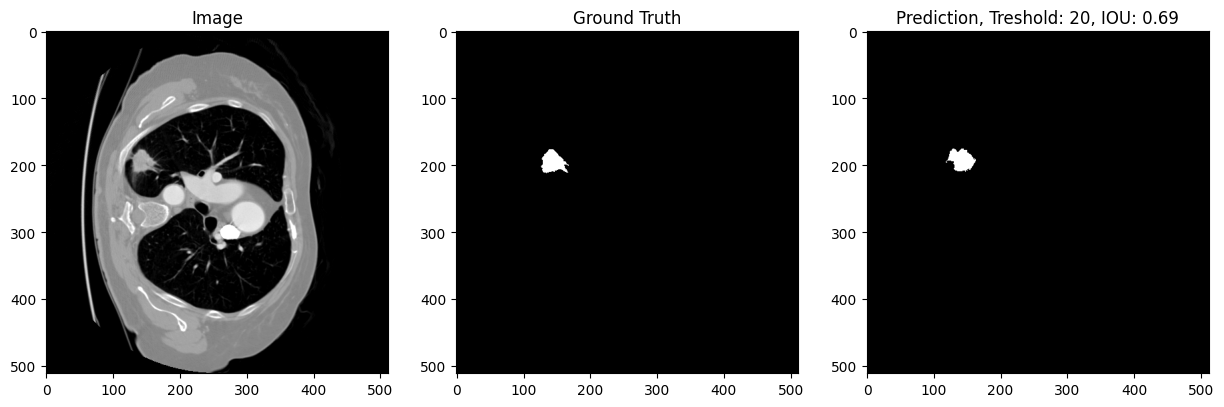

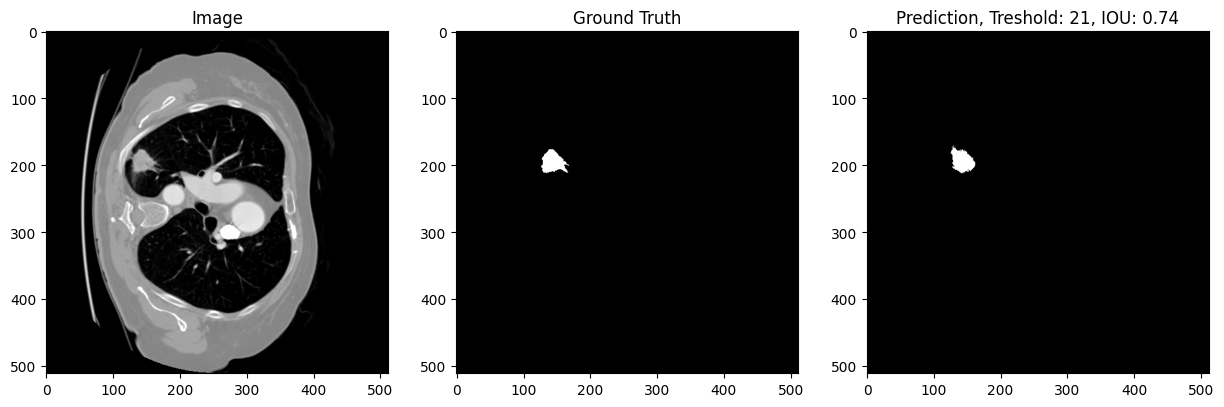

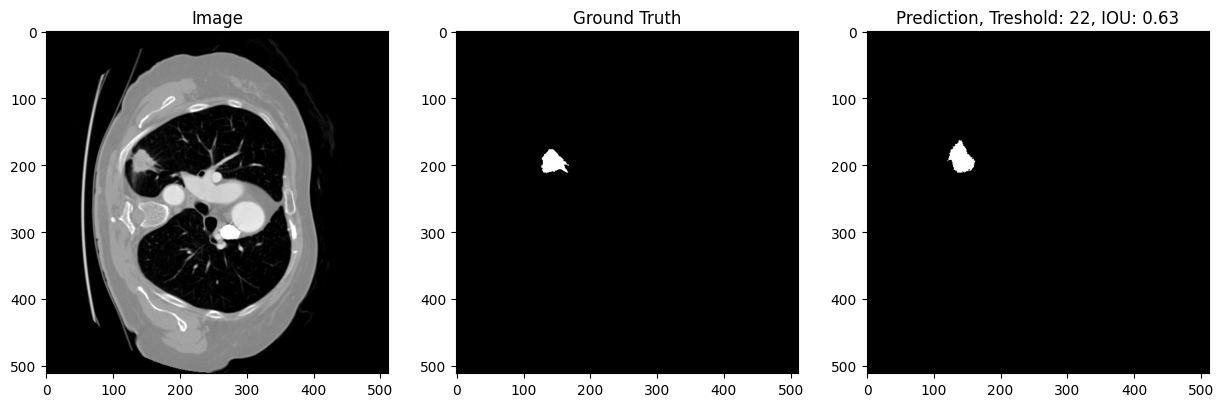

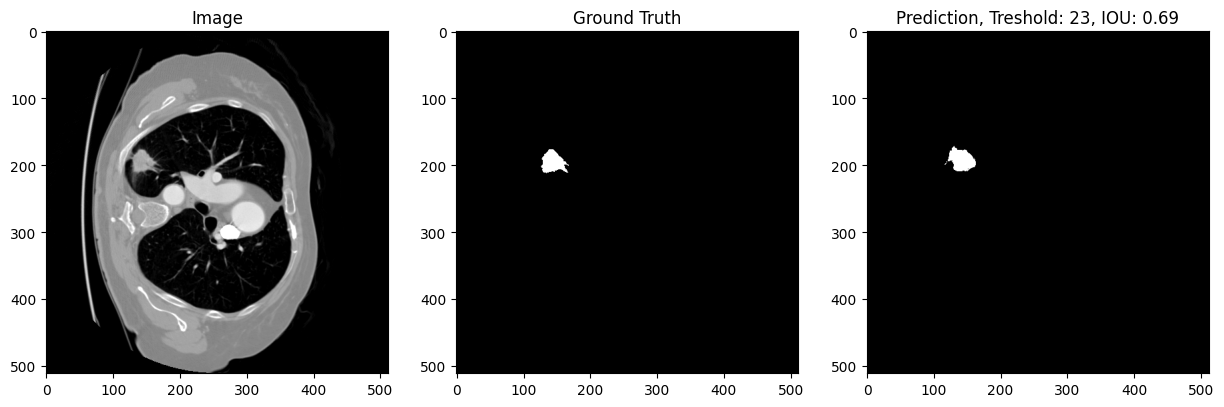

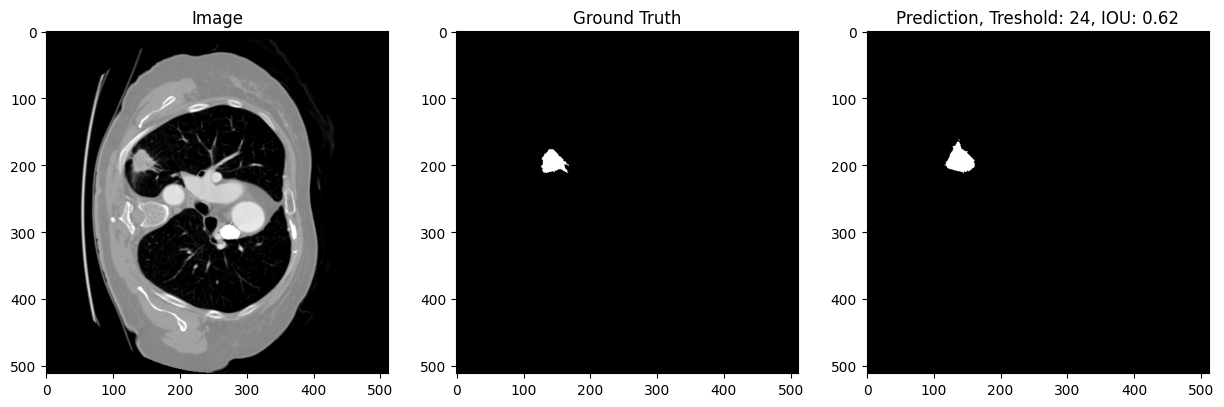

In [11]:
best_circle_size = None
best_mean_iou = 0
best_mean_f1 = 0
results_df = pd.DataFrame(columns=['circle_size', 'mean_iou', 'mean_f1'])
for circle_size in circle_size_range:
    # print(f'Computing scores for circle size: {circle_size}')
    mean_iou, mean_f1 = compute_scores(circle_size, train_loader)
    # wandb.log(
    #     {'circle_size': circle_size, 'mean_iou': mean_iou, 'mean_f1': mean_f1}
    # )
    if mean_iou > best_mean_iou:
        best_circle_size = circle_size
        best_mean_iou = mean_iou
        best_mean_f1 = mean_f1
    results_df = results_df.append({'circle_size': circle_size, 'mean_iou': mean_iou, 'mean_f1': mean_f1}, ignore_index=True)



In [9]:
results_df.describe()

,circle_size,mean_iou,mean_f1
count,79.00000,79.000000,79.000000
mean,1.02500,0.000420,0.000839
std,0.57373,0.000581,0.001159
min,0.05000,0.000000,0.000000
25%,0.53750,0.000000,0.000000
50%,1.02500,0.000141,0.000282
75%,1.51250,0.000661,0.001322
max,2.00000,0.002361,0.004710
